In [1]:
#!pip3 uninstall torch torchvision torchaudio
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import sys
sys.path.append('..')
import torch
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from src.training import train_model, eval_func
from src.models import Resnet18_FC_Changed
import os
from torchvision import datasets, models, transforms
from src.data_loader import imshow, GetDataLoaders
from src.modelvis import visualize_models
from torch.optim.lr_scheduler import StepLR


'''
The line cudnn.benchmark = True is typically used in deep learning projects that utilize the CUDA Deep Neural Network (cuDNN) library.
When cudnn.benchmark is set to True, it enables cuDNN to automatically find the best algorithm configuration for the specific 
input sizes and hardware being used. This can result in improved performance during training and inference.By enabling benchmarking, 
cuDNN will run a short benchmarking phase during the first iteration of the model to determine the optimal algorithm configuration. 
This configuration is then cached and used for subsequent iterations, leading to faster execution times.
It's important to note that enabling benchmarking may introduce some overhead during the initial benchmarking phase, so it is typically 
recommended to use it when the input sizes are consistent throughout the training process.
Overall, setting cudnn.benchmark to True can help optimize the performance of deep learning models that use cuDNN.
'''
cudnn.benchmark = True

'''
The line plt.ion() is a function call that activates interactive mode in matplotlib.
When interactive mode is enabled, any plot that is created will be displayed immediately 
and can be updated dynamically. This means that you can modify the plot after it is displayed, 
such as changing the data or adding annotations, and the changes will be reflected in real-time.
'''
plt.ion()

Device: cuda:0


### Hyperparameters

In [3]:
T_0 = 1000 # Number of iterations for the first restart.
LEARNING_RATE=0.001 # 0.0001
WEIGHT_DECAY=0.0005 # 0.000001
NUM_EPOCHS=15
BATCH_SIZE=64
MOMENTUM=0.9
num_of_classes = 64
STEP_SIZE=7
GAMMA=0.01

### Data loading parameters

In [4]:
SHUFFLE=True
WORKERS=16
num_images = 8

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_dir = '..\\data\\miniImageNet'
dataloaders, class_names, dataset_sizes  = GetDataLoaders(data_dir, BATCH_SIZE, SHUFFLE, num_workers=WORKERS)

train_loader = dataloaders['train']
validation_loader = dataloaders['val']
test_loader = dataloaders['test']

In [6]:
criterion = torch.nn.CrossEntropyLoss()

Please wait patiently, it may take some seconds...
Epoch 0/14
----------
train Loss: 0.0474 Acc: 0.2968
val Loss: 0.0317 Acc: 0.5115

Epoch 1/14
----------
train Loss: 0.0266 Acc: 0.5736
val Loss: 0.0226 Acc: 0.6223

Epoch 2/14
----------
train Loss: 0.0208 Acc: 0.6492
val Loss: 0.0192 Acc: 0.6720

Epoch 3/14
----------
train Loss: 0.0180 Acc: 0.6869
val Loss: 0.0176 Acc: 0.6952

Epoch 4/14
----------
train Loss: 0.0164 Acc: 0.7129
val Loss: 0.0166 Acc: 0.7083

Epoch 5/14
----------
train Loss: 0.0151 Acc: 0.7348
val Loss: 0.0160 Acc: 0.7168

Epoch 6/14
----------
train Loss: 0.0141 Acc: 0.7477
val Loss: 0.0154 Acc: 0.7224

Epoch 7/14
----------
train Loss: 0.0132 Acc: 0.7637
val Loss: 0.0149 Acc: 0.7273

Epoch 8/14
----------
train Loss: 0.0125 Acc: 0.7734
val Loss: 0.0144 Acc: 0.7372

Epoch 9/14
----------
train Loss: 0.0119 Acc: 0.7842
val Loss: 0.0143 Acc: 0.7350

Epoch 10/14
----------
train Loss: 0.0113 Acc: 0.7912
val Loss: 0.0142 Acc: 0.7391

Epoch 11/14
----------
train Loss: 

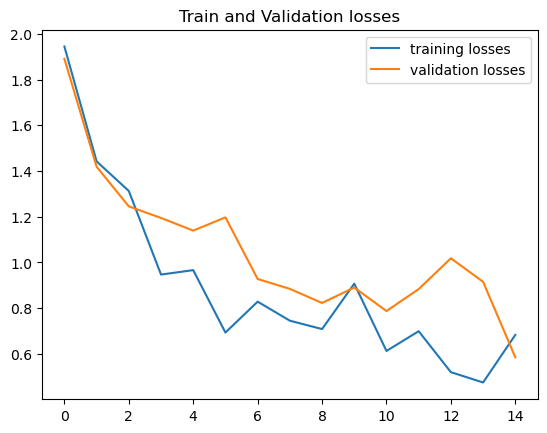


Accuracy on testing data: 0.742188


In [7]:
from src.models import Resnet18_FC_Changed
net = Resnet18_FC_Changed(num_of_classes).to(device)
for p in net.parameters():
    p.requires_grad = True
net.train()
optimizer = torch.optim.SGD(params= net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print('Please wait patiently, it may take some seconds...')
best_model = train_model(net, dataloaders, criterion, optimizer, scheduler, NUM_EPOCHS, dataset_sizes)
save_path = '..\\data\\models\\best_model_Resnet18.pth'
torch.save(best_model.state_dict(), save_path)

eval_acc = eval_func(best_model, dataloaders['test'])
print('')
print('Accuracy on testing data: %f' % eval_acc)

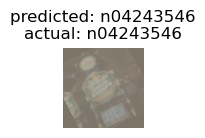

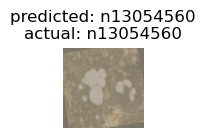

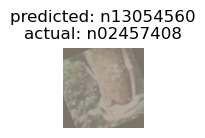

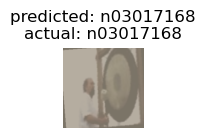

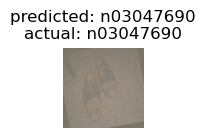

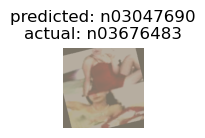

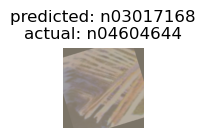

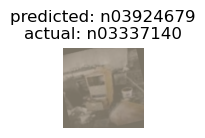

In [8]:
best_model.load_state_dict(torch.load(save_path))
visualize_models(best_model, dataloaders, num_images, class_names)